In [1]:
import pandas as pd
import ipfn
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## Load Data

In [2]:
# Read in individual data
inds = pd.read_csv('../data/London_inds.csv',index_col=0)
inds.head()

,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,sex_age_eth
0,22445,f,25-34,White,Employed,Public,Car,Bike,f25_34White
1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,f35_44White
2,2853965,f,25-34,White,Employed,Public,NoCar,Bike,f25_34White
3,68002725,f,55-64,Asian,Employed,inapplicable,NoCar,NoBike,f55_64Asian
4,68021765,f,55-64,Black,Employed,Car,Car,Bike,f55_64Black


In [3]:
# As we'll use worktrav as a constraint, we'll have to remove the individuals with missing (n=)
inds = inds.drop(inds[inds['worktrav'] == 'missing'].index)
# reindex
inds.reset_index(drop=True,inplace=True)
len(inds)

6085

In [4]:
# Read in constraints data
cons = pd.read_csv('../data/WF_cons.csv',index_col=0)
cons.head()

,GEO_CODE,f16_24Asian,f16_24Black,f16_24Mixed,f16_24Other,f16_24White,f25_34Asian,f25_34Black,f25_34Mixed,f25_34Other,...,m65_74White,Employed,SelfEmployed,NotEmployed,Car,Public,Cycle,Walk,Home,inapplicable
0,E05000590,194,243,69,35,311,301,264,57,42,...,139,4441,1377,4565,1539,3788,185,348,469,4054
1,E05000591,231,300,76,28,311,366,284,44,75,...,127,4105,1149,4374,1200,3785,145,291,345,3862
2,E05000592,145,179,76,20,361,279,186,51,75,...,189,5085,1360,3697,2243,3234,197,446,537,3485
3,E05000593,23,39,35,9,389,54,44,26,9,...,457,3643,961,2651,2228,1714,50,212,515,2536
4,E05000594,53,72,41,22,425,76,44,25,25,...,389,3922,975,2972,2652,1614,55,225,481,2842


In [5]:
# Create ind dataframe to match constraints table for verification etc.
# First make a dataframe of zeros with the same fields as cons
ind_catr = pd.DataFrame(np.zeros(shape=(len(inds),len(cons.columns[1:]))), columns=cons.columns[1:])
# Now iterate through the inds file and update the binary table as required.
for idx,row in inds.iterrows():
    # Update sex_age_eth
    ind_catr.loc[idx,row['sex_age_eth']] = 1
    # update employ
    ind_catr.loc[idx,row['employ']] = 1
    # update worktrav
    ind_catr.loc[idx,row['worktrav']] = 1
ind_catr.head()

,f16_24Asian,f16_24Black,f16_24Mixed,f16_24Other,f16_24White,f25_34Asian,f25_34Black,f25_34Mixed,f25_34Other,f25_34White,...,m65_74White,Employed,SelfEmployed,NotEmployed,Car,Public,Cycle,Walk,Home,inapplicable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Iterative Proportional Fitting #1
One dimensionsal on sex-age-ethnicity, gives a perfect fit on constraints.

In [8]:
# 1d iterative proportional fitting on sex_age_eth
weights = np.ones((len(inds),len(cons))) # weights matrix, 6081 individuals (rows) x 20 wards (columns)

# Overal marginal distribution of individuals by constraints
ind_agg = ind_catr.sum(axis=0)
# marginal distribution of indivuals by zone
ind_agg_zone = cons.drop('GEO_CODE',axis=1).apply(lambda x: 1.0*ind_agg, axis=1)

categories = cons.columns[1:61]

for i in range(0,len(cons)):
    for j in categories:
        index = ind_catr.loc[:,j] == 1
        weights[index,i] = (weights[index, i] * cons.loc[i,j]) / ind_agg_zone.loc[i, j]


In [9]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()
for i in range(0,len(cons)):
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*weights[:,i],axis=0).sum(axis=0)

In [10]:
np.corrcoef(ind_agg_weight.values[:,range(0,60)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)].ravel())[0,1]

1.0

## Iterative Proportional Fitting #2
Two dimensional on age-sex-ethnicity and employment as employed, self-employed, not employed. Perfect fit.

In [11]:
ind_cat = inds[['sex_age_eth','employ']].copy()

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,range(61,64)]
    
    aggregates = [sex_age_eth,employ]
    dimensions = [['sex_age_eth'],['employ']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [12]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,63)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,63)].ravel())[0,1]

1.0

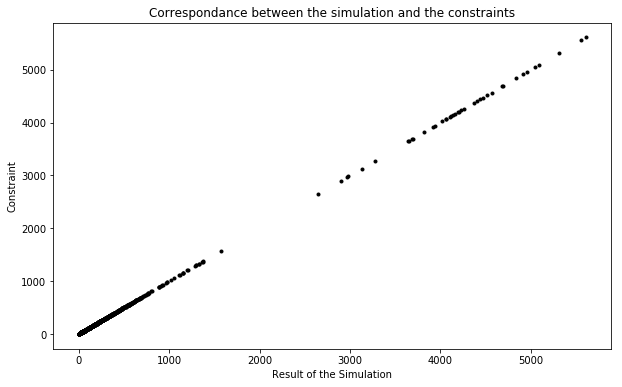

In [13]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,63)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,63)].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #3
Two dimensional on age-sex-ethnicity and employment as (employed + self-employed), not employed. 
Perfect fit on weights. As it's not clear whether dividing employed and self-employed offers much, I'll move forwards with this.

In [25]:
ind_cat = inds[['sex_age_eth','employ']].copy()
# Recode employ to combine Employed and SelfEmployed
ind_cat['employ2'] = ind_cat['employ'].apply(lambda x: 'Employ2' if x in ['Employed','SelfEmployed'] else 'NotEmployed')

# Make combined Employed and Self-Employed marginal totals
cons['Employ2'] = cons[['Employed','SelfEmployed']].sum(axis=1)

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,[70,63]]
    
    aggregates = [sex_age_eth,employ]
    dimensions = [['sex_age_eth'],['employ2']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [26]:
# Overal marginal distribution of individuals by constraints
ind_agg = ind_catr.sum(axis=0)
# Manually add employed + self-employed value
ind_agg = ind_agg.append(pd.Series([3565],index=['Employ2']))
# marginal distribution of individuals by zone
ind_agg_zone = cons.drop('GEO_CODE',axis=1).apply(lambda x: 1.0*ind_agg, axis=1)
# Add employ2 to ind_catr
ind_catr['Employ2'] = ind_catr[['Employed','SelfEmployed']].sum(axis=1)

ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[69,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[69,62]].ravel())[0,1]

1.0

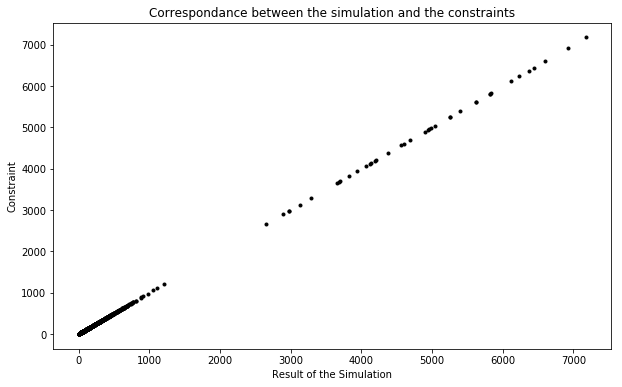

In [27]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[69,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[69,62]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #4
Two dimensional on age-sex-ethnicity and travel to work. NB travel to work responses basically proxy employment anyway.
Fit is near perfect, and contains important info on commute mode.

In [32]:
# Inapplicable captures people that aren't employed
# Home captures people that work at or from home
# Taken together people responding to worktrav could be thought of a self-identified 'commuters' of one sort or another.
pd.crosstab(ind_cat['employ2'],inds['worktrav'])

worktrav,Car,Cycle,Home,Public,Walk,inapplicable
employ2,,,,,,
Employ2,1110,145,231,1579,300,204
NotEmployed,43,4,15,80,17,2357


In [36]:
cons.iloc[:,[64,65,66,67,68,69]]

,Car,Public,Cycle,Walk,Home,inapplicable
0,1539,3788,185,348,469,4054
1,1200,3785,145,291,345,3862
2,2243,3234,197,446,537,3485
3,2228,1714,50,212,515,2536
4,2652,1614,55,225,481,2842
5,1523,3257,201,520,424,3757
6,1602,4906,232,428,471,3741
7,2318,2158,125,353,473,2724
8,2413,1877,87,274,403,2873
9,1395,4545,283,415,557,3669


In [37]:
ind_cat = inds[['sex_age_eth','worktrav']].copy()

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    worktrav =  cons.iloc[i,[64,65,66,67,68,69]]
    
    aggregates = [sex_age_eth,worktrav]
    dimensions = [['sex_age_eth'],['worktrav']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [38]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67,68]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67,68]].ravel())[0,1]

1.0

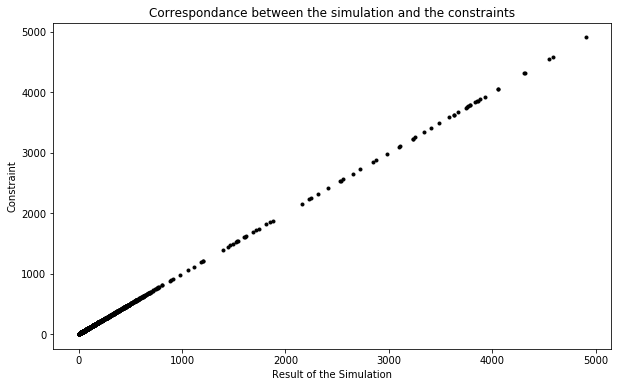

In [39]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67,68]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67,68]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #5
Three dimensional on sex-age-ethnicity, employment (2 category) and commute mode. Seems to work.

In [46]:
ind_cat = inds[['sex_age_eth','employ','worktrav']].copy()
# Recode employ to combine Employed and SelfEmployed
ind_cat['employ2'] = ind_cat['employ'].apply(lambda x: 'Employ2' if x in ['Employed','SelfEmployed'] else 'NotEmployed')

# Make combined Employed and Self-Employed marginal totals
cons['Employ2'] = cons[['Employed','SelfEmployed']].sum(axis=1)

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,[70,63]]
    worktrav =  cons.iloc[i,[64,65,66,67,68,69]]
    
    aggregates = [sex_age_eth,worktrav,employ]
    dimensions = [['sex_age_eth'],['worktrav'],['employ2']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [47]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67,68]+[69,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67,68]+[69,62]].ravel())[0,1]

1.0

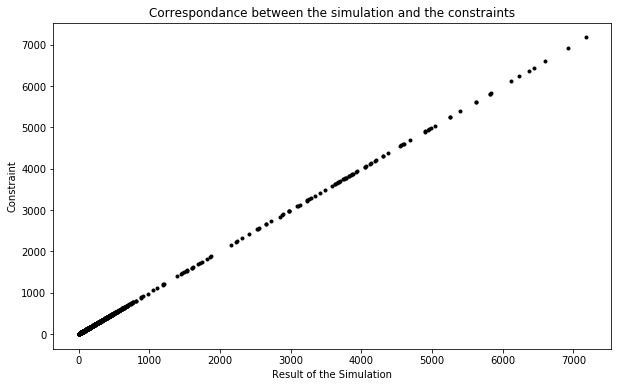

In [48]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[69,62]+[63,64,65,66,67,68]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[69,62]+[63,64,65,66,67,68]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Integerisation and Expansion
Using 3D sex-age-eth, employment and worktrav. 

In [49]:
# Truncate, replicate, sample 'TRS' integerisation approach.
def int_trs(weights):
    # convert to a vector if required
    xv = np.array(weights).ravel()
    # truncate - just get the integer part of the weight
    xint = np.floor(xv)
    # Get the decimal bit of the weight
    r = xv - xint
    # Work out the deficit population
    frac_sum = round(r.sum())
    # Sample based upon the deficit bit
    xs = np.random.choice(len(xv),int(frac_sum),True,r/r.sum())
    # Get the result of the deficit part
    topup = np.bincount(xs,minlength=len(xv))
    return xint + topup

def int_expand_vector(weights):
    return np.repeat(range(0,len(weights)),weights.astype(int))

In [97]:
indivs = []
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    # Integerise and expand - gives a list of the ind ids for the ward
    ints = int_expand_vector(int_trs(ind_cat['weight_'+ ward]))
    # Select the relevant individuals and cols
    temp = inds.iloc[ints][['pidp','sex','age_6cat','eth_5cat','employ','worktrav','caruse','cycleuse']]
    temp['ward'] = ward
    indivs.append(temp)
ints_df = pd.concat(indivs)
ints_df.reset_index(inplace=True)
ints_df.head()

,index,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,ward
0,0,22445,f,25-34,White,Employed,Public,Car,Bike,E05000590
1,0,22445,f,25-34,White,Employed,Public,Car,Bike,E05000590
2,0,22445,f,25-34,White,Employed,Public,Car,Bike,E05000590
3,0,22445,f,25-34,White,Employed,Public,Car,Bike,E05000590
4,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,E05000590


## Basic Checks
Overall, simulated vs. observed differences are relatively small on constraints, suggesting a decent model.

In [98]:
# sex
# We would expect the constraint variables to be pretty much exact.
# Looks good, slight variation is due to the integerisation process.
print "simulation male", ints_df['sex'].value_counts(normalize=True)['m']
print "observed male", cons[cons.columns[cons.columns.str.contains(r'[m][0-9]')]].sum(axis=1).sum()/float(cons[['Employ2','NotEmployed']].sum(axis=1).sum())

simulation male 0.502173025165
observed male 0.502413890605


In [99]:
# sex by ward - differences are all less than 5% difference.
male_cons = (cons[cons.columns[cons.columns.str.contains(r'[m][0-9]')]].sum(axis=1)/cons[['Employ2','NotEmployed']].sum(axis=1)).to_frame()
male_cons.rename(columns={0:'obs_male'},inplace=True)
male_inds = pd.melt(ints_df.groupby('ward')['sex'].value_counts(normalize=True).to_frame()).iloc[range(0,39,2)].reset_index(drop=True)
male_inds.rename(columns={'value':'sim_male'},inplace=True)
sex_compare = male_inds.merge(male_cons.merge(cons['GEO_CODE'].to_frame(),left_index=True,right_index=True),left_index=True,right_index=True)
sex_compare['diff'] = abs(sex_compare['sim_male']-sex_compare['obs_male'])
sex_compare

,variable,sim_male,obs_male,GEO_CODE,diff
0,sex,0.534720,0.532987,E05000590,0.001734
1,sex,0.501870,0.504778,E05000591,0.002908
2,sex,0.503352,0.499901,E05000592,0.003451
3,sex,0.514128,0.485320,E05000593,0.028808
4,sex,0.514170,0.487610,E05000594,0.026560
5,sex,0.515699,0.519314,E05000595,0.003615
6,sex,0.522320,0.522320,E05000596,0.000000
7,sex,0.519077,0.476751,E05000597,0.042326
8,sex,0.523149,0.476221,E05000598,0.046928
9,sex,0.538936,0.538384,E05000599,0.000552


In [100]:
# age - looks to be in the right ballpark overall
print "Simulated age counts"
print ints_df['age_6cat'].value_counts(normalize=True).sort_index()


ages = ['16_24','25_34','35_44','45_54','55_64','65_74']
age_df = [cons['GEO_CODE']]
for age in ages:
    age_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(r'[m,f]' + age)]].sum(axis=1),name=age))

age_df = pd.concat(age_df,axis=1)
age_df['total'] = age_df[age_df.columns[1:]].sum(axis=1)
print ""
print "Observed age counts"
print age_df[age_df.columns[1:-1]].sum(axis=0)/age_df[age_df.columns[1:-1]].sum(axis=0).sum()

Simulated age counts
16-24    0.170973
25-34    0.265209
35-44    0.216082
45-54    0.167276
55-64    0.110002
65-74    0.070458
Name: age_6cat, dtype: float64

Observed age counts
16_24    0.171690
25_34    0.265350
35_44    0.216543
45_54    0.165783
55_64    0.110400
65_74    0.070233
dtype: float64


In [101]:
# age by ward - percentage errors are small, and less than 1% in all cases.
age_inds = ints_df.groupby('ward')['age_6cat'].value_counts(normalize=True).sort_index().unstack()
age_df = age_df.merge(age_inds,left_on = 'GEO_CODE',right_index=True)
cols = []
for age in ages:
    cols.append('per_err_' + age)
    age_df['per_err_' + age] = age_df.apply(lambda x: abs((x[age]/float(x['total']) - x[age.replace('_','-')])*100.0) , axis=1)

age_df[cols]

,per_err_16_24,per_err_25_34,per_err_35_44,per_err_45_54,per_err_55_64,per_err_65_74
0,0.134836,0.500819,0.414138,0.105942,0.240778,0.394876
1,0.145409,0.436228,0.010386,0.155796,0.062318,0.083091
2,0.147900,0.246500,0.157760,0.197200,0.384540,0.049300
3,0.055134,0.220538,0.041351,0.192970,0.124052,0.192970
4,0.393951,0.114373,0.050832,0.724361,0.330410,0.063540
5,0.175584,0.000000,0.175584,0.072299,0.072299,0.000000
6,0.026362,0.149385,0.026362,0.237258,0.105448,0.035149
7,0.772911,0.466200,0.355785,0.073611,0.184026,0.061342
8,0.138766,0.037845,0.075691,0.100921,0.416299,0.063076
9,0.138071,0.018409,0.009205,0.147275,0.036819,0.036819


In [102]:
# ethnicity - looks to be in the right ballpark overall
print "Simulated Ethnicity counts"
print ints_df['eth_5cat'].value_counts(normalize=True).sort_index()

eths = ['Asian','Black','Mixed','Other','White']
eth_df = [cons['GEO_CODE']]
for eth in eths:
    eth_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(eth)]].sum(axis=1),name=eth))

eth_df = pd.concat(eth_df,axis=1)
eth_df['total'] = eth_df[eth_df.columns[1:]].sum(axis=1)
print ""
print "Observed Ethnicity counts"
print eth_df[eth_df.columns[1:-1]].sum(axis=0)/eth_df[eth_df.columns[1:-1]].sum(axis=0).sum()

Simulated Ethnicity counts
Asian    0.208579
Black    0.164851
Mixed    0.037046
Other    0.040816
White    0.548707
Name: eth_5cat, dtype: float64

Observed Ethnicity counts
Asian    0.208726
Black    0.165490
Mixed    0.036360
Other    0.040659
White    0.548765
dtype: float64


In [103]:
# ethnicity by ward. All errors less than 0.55%
eth_inds = ints_df.groupby('ward')['eth_5cat'].value_counts(normalize=True).sort_index().unstack()
eth_df = eth_df.merge(eth_inds,left_on = 'GEO_CODE',right_index=True)

cols = []
for eth in eths:
    cols.append('per_err_' + eth)
    eth_df['per_err_' + eth] = eth_df.apply(lambda x: abs((x[eth  +"_x"]/float(x['total']) - x[eth  +"_y"])*100.0) , axis=1)

eth_df[cols]

,per_err_Asian,per_err_Black,per_err_Mixed,per_err_Other,per_err_White
0,0.019262,0.028893,0.019262,0.019262,0.048156
1,0.010386,0.041545,0.062318,0.020773,0.031159
2,0.423979,0.335240,0.088740,0.118320,0.118320
3,0.220538,0.041351,0.179187,0.137836,0.220538
4,0.025416,0.139789,0.127081,0.088957,0.330410
5,0.041314,0.041314,0.154927,0.103284,0.258211
6,0.360281,0.096661,0.175747,0.087873,0.175747
7,0.318979,0.478469,0.049074,0.122684,0.012268
8,0.163996,0.063076,0.126151,0.126151,0.100921
9,0.202504,0.000000,0.147275,0.055228,0.110457


In [104]:
# Mode of travel to work. - looks decent
print "Simulated work travel mode counts"
print ints_df['worktrav'].value_counts(normalize=True).sort_index()

modes = ['Car','Cycle','Home','Public','Walk','inapplicable']
trav_df = [cons['GEO_CODE']]
for mode in modes:
    trav_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(mode)]].sum(axis=1),name=mode))

trav_df = pd.concat(trav_df,axis=1)
trav_df['total'] = trav_df[trav_df.columns[1:]].sum(axis=1)
print ""
print "Observed work travel mode counts"
print trav_df[trav_df.columns[1:-1]].sum(axis=0)/trav_df[trav_df.columns[1:-1]].sum(axis=0).sum()

Simulated work travel mode counts
Car             0.190854
Cycle           0.017374
Home            0.047639
Public          0.335164
Walk            0.039544
inapplicable    0.369425
Name: worktrav, dtype: float64

Observed work travel mode counts
Car             0.190399
Cycle           0.017311
Home            0.048136
Public          0.335431
Walk            0.039272
inapplicable    0.369451
dtype: float64


In [105]:
# mode of travel to work by ward. All errors less than 1%
trav_inds = ints_df.groupby('ward')['worktrav'].value_counts(normalize=True).sort_index().unstack()
trav_df = trav_df.merge(trav_inds,left_on = 'GEO_CODE',right_index=True)

cols = []
for mode in modes:
    cols.append('per_err_' + mode)
    trav_df['per_err_' + mode] = trav_df.apply(lambda x: abs((x[mode  +"_x"]/float(x['total']) - x[mode  +"_y"])*100.0) , axis=1)

trav_df[cols]

,per_err_Car,per_err_Cycle,per_err_Home,per_err_Public,per_err_Walk,per_err_inapplicable
0,0.202254,0.038525,0.260040,0.009631,0.038525,0.471925
1,0.041545,0.051932,0.041545,0.415455,0.062318,0.405069
2,0.039440,0.029580,0.039440,0.108460,0.157760,0.295800
3,0.027567,0.013784,0.000000,0.110269,0.124052,0.027567
4,0.292286,0.038124,0.038124,0.025416,0.050832,0.368535
5,0.051642,0.134270,0.051642,0.000000,0.041314,0.092956
6,0.105448,0.061511,0.008787,0.052724,0.008787,0.096661
7,0.184026,0.000000,0.024537,0.429395,0.073611,0.294442
8,0.201842,0.088306,0.025230,0.176612,0.025230,0.063076
9,0.230118,0.018409,0.110457,0.266937,0.202504,0.036819


In [115]:
# The current model overpredicts self-employed by c.1.7% at the expense of employed.
# We don't specifically constrain on employed/self-employed due to cell sizes, so overall I think this is ok.
print "Simulation employment"
print ints_df['employ'].value_counts(normalize=True)

emps = ['Employed','NotEmployed','SelfEmployed']
emp_df = [cons['GEO_CODE']]
for emp in emps:
    emp_df.append(pd.Series(cons[cons.columns[cons.columns.str.match(emp)]].sum(axis=1),name=emp))

emp_df = pd.concat(emp_df,axis=1)
emp_df['total'] = emp_df[emp_df.columns[1:]].sum(axis=1)
print ""
print "Observed Employment counts"
print emp_df[emp_df.columns[1:-1]].sum(axis=0)/emp_df[emp_df.columns[1:-1]].sum(axis=0).sum()

Simulation employment
Employed        0.494842
NotEmployed     0.397873
SelfEmployed    0.107285
Name: employ, dtype: float64

Observed Employment counts
Employed        0.477929
NotEmployed     0.398025
SelfEmployed    0.124046
dtype: float64


In [116]:
# Access to a car or van comes in a roughly 50-50
ints_df['caruse'].value_counts(normalize=True)

NoCar    0.509195
Car      0.490805
Name: caruse, dtype: float64

In [117]:
# Car access by ward. Clear variation in predicted access to car by ward. High = 61.5% low = 42.4%. Almost a 10% difference.
ints_df.groupby('ward')['caruse'].value_counts(normalize=True).sort_index()

ward       caruse
E05000590  Car       0.431860
           NoCar     0.568140
E05000591  Car       0.424803
           NoCar     0.575197
E05000592  Car       0.509959
           NoCar     0.490041
E05000593  Car       0.614748
           NoCar     0.385252
E05000594  Car       0.605922
           NoCar     0.394078
E05000595  Car       0.462714
           NoCar     0.537286
E05000596  Car       0.450879
           NoCar     0.549121
E05000597  Car       0.568274
           NoCar     0.431726
E05000598  Car       0.584584
           NoCar     0.415416
E05000599  Car       0.463273
           NoCar     0.536727
E05000600  Car       0.469506
           NoCar     0.530494
E05000601  Car       0.453485
           NoCar     0.546515
E05000602  Car       0.574575
           NoCar     0.425425
E05000603  Car       0.458035
           NoCar     0.541965
E05000604  Car       0.429347
           NoCar     0.570653
E05000605  Car       0.466712
           NoCar     0.533288
E05000606  Car       0

## Predicting bicycle access
We have a slight issue with bicycle access, as the ethnic boost part of the survey wasn't asked about travel behaviours. However, we really need those people to have enough people from ethnic minority populations to create a reasonable synthetic population. This means that 1/3 of the synthetic population has missing on bicycle access.

Therefore, we'll try to model the conditional probability of having bicycle access using the complete case data, and then randomly assign bicycle acccess based on those probabilities to the people who are missing.

In [118]:
# There is a lot of missing on bike use because the ethnic boost don't get asked the question.
ints_df['cycleuse'].value_counts(normalize=True)

missing    0.362963
NoBike     0.346317
Bike       0.290719
Name: cycleuse, dtype: float64

In [119]:
cycle = inds[inds['cycleuse'] != 'missing'] # dataset of 3,893 people.

In [121]:
# cycling is a binary outcome, so we'll use a logistic regression.
from statsmodels.discrete.discrete_model import Logit

# recode outcome (cycling) to binary
cycle['cycle'] = cycle['cycleuse'].apply(lambda x: 1 if x == 'Bike' else 0)

C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [122]:
# Much more likely to have access to a bicycle if male compared to female (OR: 1.92 - almost twice as likely.)
res = Logit.from_formula('cycle~sex',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.667219
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3891
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:                 0.01861
Time:                        17:18:39   Log-Likelihood:                -2597.5
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 3.261e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6180      0.045    -13.860      0.000      -0.705      -0.531
sex[T.m]       0.6525      0.066      9.875      0.000       0.523       0.782
==============================================================================
"""

In [123]:
# Much more likely to have access to a bicycle if younger
res = Logit.from_formula('cycle~age_6cat',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.671071
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3887
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:                 0.01294
Time:                        17:19:09   Log-Likelihood:                -2612.5
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 2.102e-13
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0222      0.080      0.279      0.781      -0.134       0.178
age_6cat[T.25-34]    -0.3513      0.113     -3.122      0.002      -0.572      -0.131
age_6cat[T.35-44]    -0.3382      0.107     -3.162      0.002      -0.548      -0.129
age_6cat[T.45-54]    -0.1745      0.105     -1.661      0.097      -0.381       0.031
age_6cat[T.55-64]    -0.6698      0.120     -5.598      0.000      -0.904      -0.435
age_6cat[T.65-74]    -0.9314      0.137     -6.821      0.000      -1.199      -0.664
=====================================================================================
"""

In [124]:
# Much more likely to have access to a bicycle if White, Mixed, less likely if Asian, Other
res = Logit.from_formula('cycle~eth_5cat',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.659838
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3888
Method:                           MLE   Df Model:                            4
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:                 0.02946
Time:                        17:19:31   Log-Likelihood:                -2568.8
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 1.075e-32
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8424      0.064    -13.195      0.000      -0.968      -0.717
eth_5cat[T.Black]     0.2896      0.099      2.924      0.003       0.095       0.484
eth_5cat[T.Mixed]     0.7006      0.148      4.738      0.000       0.411       0.990
eth_5cat[T.Other]     0.2575      0.210      1.227      0.220      -0.154       0.669
eth_5cat[T.White]     0.9413      0.081     11.656      0.000       0.783       1.100
=====================================================================================
"""

In [125]:
cycle['employ2'] = cycle['employ'].apply(lambda x: 'Employed' if x != 'NotEmployed' else 'NotEmployed')

# Much more likely to have access to a bicycle if employed
res = Logit.from_formula('cycle~employ2',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.673338
         Iterations 4


C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3891
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:                0.009606
Time:                        17:20:21   Log-Likelihood:                -2621.3
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 9.967e-13
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1422      0.041     -3.430      0.001      -0.224      -0.061
employ2[T.NotEmployed]    -0.4775      0.067     -7.081      0.000      -0.610      -0.345
==========================================================================================
"""

In [126]:
# More likely to have access to a bicycle if also have access to a car
res = Logit.from_formula('cycle~caruse',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.676093
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3891
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:                0.005554
Time:                        17:20:49   Log-Likelihood:                -2632.0
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 5.887e-08
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1677      0.044     -3.832      0.000      -0.253      -0.082
caruse[T.NoCar]    -0.3548      0.066     -5.406      0.000      -0.483      -0.226
===================================================================================
"""

In [127]:
# Fully adjusted model
cycle_model = Logit.from_formula('cycle~sex+age_6cat+eth_5cat+employ2+caruse',data=cycle).fit()
cycle_model.summary()

Optimization terminated successfully.
         Current function value: 0.628420
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3880
Method:                           MLE   Df Model:                           12
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:                 0.07567
Time:                        17:21:01   Log-Likelihood:                -2446.4
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 2.851e-78
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.3374      0.131     -2.567      0.010      -0.595      -0.080
sex[T.m]                   0.6293      0.070      9.000      0.000       0.492       0.766
age_6cat[T.25-34]         -0.6074      0.124     -4.902      0.000      -0.850      -0.365
age_6cat[T.35-44]         -0.6390      0.121     -5.276      0.000      -0.876      -0.402
age_6cat[T.45-54]         -0.5243      0.119     -4.408      0.000      -0.757      -0.291
age_6cat[T.55-64]         -1.0981      0.132     -8.326      0.000      -1.357      -0.840
age_6cat[T.65-74]         -1.4200      0.152     -9.356      0.000      -1.717      -1.123
eth_5cat[T.Black]          0.3875      0.104      3.729      0.000       0.184       0.591
eth_5cat[T.Mixed]          0.7066      0.153      4.632      0.000       0.408       1.006
eth_5cat[T.Other]          0.3342      0.217      1.543      0.123      -0.090       0.759
eth_5cat[T.White]          1.0807      0.086     12.544      0.000       0.912       1.250
employ2[T.NotEmployed]    -0.1947      0.082     -2.366      0.018      -0.356      -0.033
caruse[T.NoCar]           -0.3360      0.077     -4.378      0.000      -0.486      -0.186
==========================================================================================
"""

In [128]:
# Now get the people with missing on cycleuse
missing = inds[inds['cycleuse'] == 'missing']
# derive employ2 variable
missing['employ2'] = missing['employ'].apply(lambda x: 'Employed' if x != 'NotEmployed' else 'NotEmployed')

# Get the predicted probabilities
missing['prob_cycle'] = cycle_model.predict(missing)
missing.head()

C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,sex_age_eth,employ2,prob_cycle
6,68021781,m,16-24,Black,NotEmployed,inapplicable,NoCar,missing,m16_24Black,NotEmployed,0.537128
50,68912575,m,16-24,White,NotEmployed,inapplicable,NoCar,missing,m16_24White,NotEmployed,0.698865
66,68945891,f,16-24,White,NotEmployed,inapplicable,Car,missing,f16_24White,NotEmployed,0.633809
124,69833965,m,65-74,White,NotEmployed,inapplicable,NoCar,missing,m65_74White,NotEmployed,0.359369
126,69833977,m,25-34,White,NotEmployed,inapplicable,NoCar,missing,m25_34White,NotEmployed,0.558356


In [129]:
# Now, for each missing in the synthetic data, find the predicted probability of that person and randomly allocate.
updates = []
for idx, row in ints_df.iterrows():
    if row['cycleuse'] == 'missing':
        #Get pidp
        pidp = row['pidp']
        # get predicted probability of cycle access from missing table
        prob = missing.loc[missing['pidp']==pidp,'prob_cycle'].values[0]
        # get random number
        rn = np.random.rand()
        update = "Bike" if rn < prob else "NoBike"
        updates.append([idx,update])
# update values
ints_df.iloc[np.array(updates)[:,0].astype(int),8] = np.array(updates)[:,1]

In [130]:
# In line with the 43% of people in the UK who have access to a bike - National Travel Survey
ints_df['cycleuse'].value_counts(normalize=True)

NoBike    0.544482
Bike      0.455518
Name: cycleuse, dtype: float64

In [131]:
# cycle access by ward - low = 42.7% high = 49.7%
ints_df.groupby('ward')['cycleuse'].value_counts(normalize=True).sort_index()

ward       cycleuse
E05000590  Bike        0.449485
           NoBike      0.550515
E05000591  Bike        0.431658
           NoBike      0.568342
E05000592  Bike        0.468152
           NoBike      0.531848
E05000593  Bike        0.493591
           NoBike      0.506409
E05000594  Bike        0.493709
           NoBike      0.506291
E05000595  Bike        0.435137
           NoBike      0.564863
E05000596  Bike        0.443497
           NoBike      0.556503
E05000597  Bike        0.480064
           NoBike      0.519936
E05000598  Bike        0.497288
           NoBike      0.502712
E05000599  Bike        0.457106
           NoBike      0.542894
E05000600  Bike        0.453417
           NoBike      0.546583
E05000601  Bike        0.458594
           NoBike      0.541406
E05000602  Bike        0.481586
           NoBike      0.518414
E05000603  Bike        0.429177
           NoBike      0.570823
E05000604  Bike        0.426729
           NoBike      0.573271
E05000605  Bike     

In [132]:
# Save the synthetic dataset
ints_df.to_csv('Synthetic_WF.csv')